In [2]:
import os
os.chdir('../')

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from cids.util import misc_funcs as misc
from cids.data import OpTCDataset
from cids.models.nn import MLP, Autoencoder

import torch
from torch import nn
from torch.nn import functional as F

In [6]:
ds = OpTCDataset(
    ds_name="cids-v5_201_train-ff--104-170-205-255-321-355-419-462",
    parts=4,
    window_size=10,
    shuffle=False,
    eval_mode=True,
    only_benign=False,
    stage=5
)
ds_eval = OpTCDataset(
    ds_name="cids-v5_201_eval-ff_eval--benign_only--503-559-609",
    parts=4,
    window_size=10,
    shuffle=False,
    eval_mode=True,
    only_benign=False,
    stage=5
)
dl = torch.utils.data.DataLoader(ds, batch_size=32)
eval_dl = torch.utils.data.DataLoader(ds_eval, batch_size=32)

In [7]:
device = "cuda:0"
model_path = "models/03_semisupervision/unsupervised/OpTC/MLPAE-201/BASE-201-1/BASE-201-1-0/ckpt.pt"
model_config = {"input_dim": 1690, "hidden_dims": [128], "output_dim":5}
encoder = MLP(**model_config)
model_config["input_dim"], model_config["output_dim"] = model_config["output_dim"], model_config["input_dim"]
decoder = MLP(**model_config)
decoder = nn.Sequential(decoder, nn.Sigmoid())

model = Autoencoder(encoder=encoder, decoder=decoder)

ckpt = torch.load(model_path, weights_only=True, map_location="cpu")
model.load_state_dict(ckpt["model_state_dict"])
model.to(device)

Autoencoder(
  (encoder): MLP(
    (input_layer): Linear(in_features=1690, out_features=128, bias=True)
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=128, out_features=5, bias=True)
    (dropout): Identity()
  )
  (decoder): Sequential(
    (0): MLP(
      (input_layer): Linear(in_features=5, out_features=128, bias=True)
      (hidden_layers): ModuleList()
      (output_layer): Linear(in_features=128, out_features=1690, bias=True)
      (dropout): Identity()
    )
    (1): Sigmoid()
  )
)

In [8]:
scores_train = []
labels_train = []

for data in dl:
    lbl = data[-1].to(device)
    inp = torch.flatten(data[0], start_dim=1)
    inp = inp.to(device)
    out = model(inp)
    scores_train.extend(torch.mean(F.mse_loss(inp, out, reduction="none"), dim=1).detach().cpu().numpy())
    labels_train.extend(lbl.detach().cpu().numpy())
    break

labels_train = torch.tensor(labels_train)
scores_train = torch.tensor(scores_train)
distance = torch.tensor(scores_train)[labels_train == 0]
q1 = torch.quantile(distance, 0.25)
q3 = torch.quantile(distance, 0.75)
iqr = q3 - q1
threshold = (q3 + 1.5 * iqr).item()

scores_eval = []
labels_eval = []

for data in eval_dl:
    lbl = data[-1].to(device)
    inp = torch.flatten(data[0], start_dim=1)
    inp = inp.to(device)
    out = model(inp)
    scores_eval.extend(torch.mean(F.mse_loss(inp, out, reduction="none"), dim=1).detach().cpu().numpy())
    labels_eval.extend(lbl.detach().cpu().numpy())

scores_eval = torch.tensor(scores_eval)
labels_eval = torch.tensor(labels_eval)

/tmp/ipykernel_485356/887035817.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance = torch.tensor(scores_train)[labels_train == 0]


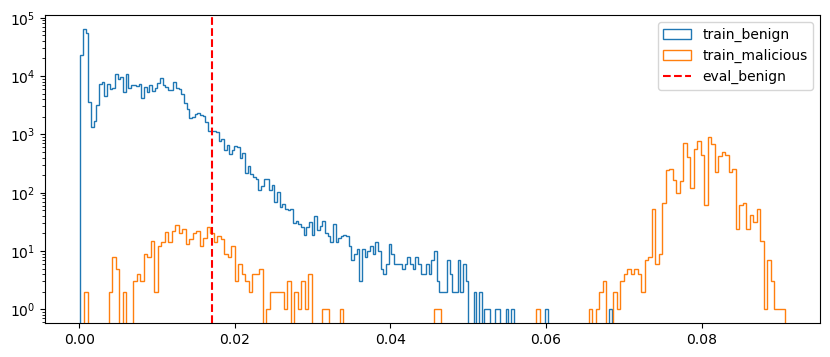

In [16]:
import json

fig = plt.figure(figsize=(10, 4))
# plt.hist(train_scores, bins=100, histtype='step', log=True)
#plt.hist(scores_train[labels_train == 0], bins=200, histtype='step', log=True)
#plt.hist(scores_train[labels_train == 1], bins=200, histtype='step', log=True)

plt.hist(scores_eval[labels_eval == 0], bins=200, histtype='step', log=True)
plt.hist(scores_eval[labels_eval == 1], bins=200, histtype='step', log=True)


# Add the threshold as a vertical red dashed line
plt.axvline(x=threshold, color='red', linestyle='--')
plt.legend(['train_benign', 'train_malicious', 'eval_benign', 'eval_malicious'])
plt.show()
plt.close(fig)